# P300 analysis from OpenVibe/BCI2000
With lots of cool preprocessing features.
source: [https://github.com/lokinou/p300_analysis_from_openvibe](https://github.com/lokinou/p300_analysis_from_openvibe)\

In [1]:
# uncomment the line wit qt below to obtain separate plots to save
%matplotlib inline
#%matplotlib qt


In [2]:
# if packages are missing, uncomment and execute here or in anaconda prompt with p300mne env
#!pip install "git+https://github.com/nbara/python-meegkit"
#!pip install statsmodels pyriemann

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import os
import mne
import pandas as pd
import itertools
import re
from pathlib import Path
# LDA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

## Parameters

if you don't know how to convert the .ov files, please check my [ov to gdf tutorial](https://github.com/lokinou/openvibe_to_gdf_tutorial)\
<span style="color:red">**Take the time to manually define !!!:**</span>
- electrodes names
- time_epoch and time_baseline
- nb_k_splits to be a multiple of the number of trials
- row, col and nb sequences for OpenVibe

In [4]:
# Directory containing the gdf files
data_dir=r"./data_sample"  # folder is scanned for .gdf or .dat files

# Define the electrodes here (for the provided sample file)
cname = None
cname = ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']  #bci2000 sample
#cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']  # openvibe sample
#cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz', 'bad1', 'bad2']  # openvibe sample
# ERP analysis parameters (values in sec)
time_epoch = (-.200, .600)  # epoch (tmin, tmax) 200ms prior to stimulus
time_baseline = (-.200, 0)  # (baseline_tmin, baseline_tmax),  should contain the baseline

# resample for faster processing
resample_freq = None
resample_freq = 256 # Hz


In [5]:
# LDA
resample_LDA = 32 # Hz, dramatically speeds up LDA training and classification
nb_k_splits = 5  # number of trials in files must be a mu

# Display more plots and figures
skip_slow_ERP_plot = False  # skip the channelwise ERP plot
display_preprocessing_plots = True
display_all_erp_plots = True
export_figures = True

reject_channels_full_of_artifacts = False
drop_bad_epochs = False
reject_artifactual_epochs = reject_channels_full_of_artifacts # do not reject epochs if you dont reject channels or use CSD
artifact_threshold = 100e-6
ratio_tolerated_artifacts = 0.3  # if 30% of artifacts in 200ms windows, then the channel is rejected

# OpenVibe parameters
ov_nb_sequences = 10
ov_nb_row_stims = 7
ov_nb_col_stims = 7

advanced parameters

In [6]:
# Signal Preprocessing
apply_infinite_reference = False  # re-referencing
apply_ASR = False  # use Artifact Subspace Reconstruction (artifact removal)
apply_CSD = False  # use Current Source Density (spatial filter)

fig_folder = './out'  # output for figures

In [7]:
# For internal processing, stimuli begin at 100 to discriminate from MNE usually using stimuli 1 and 0 as target and non-target 
apply_resample = resample_freq is not None
stimulus_padding  = 100
ov_stimulus_begin  = 33025
data_type= None  # bci2000 or openvibe or None for autodetection

## Load the data files

In [8]:
from BCI2kReader import BCI2kReader as b2k
from BCI2kReader import FileReader as f2k

raws = []

def extract_annotations(filename, verbose=False):
    display_preprocessing_plots = False
    file= b2k.BCI2kReader(filename)

    if verbose:
        print(file.states)
    target_states = np.squeeze(file.states['StimulusType'])
    stimulus_codes = np.squeeze(file.states['StimulusCode'])
    if 'StimulusBegin' in file.states.keys():
        stimulus_begin = np.squeeze(file.states['StimulusBegin'])
    else:
        stimulus_begin = np.squeeze(file.states['Flashing'])
    
    phase = np.squeeze(file.states['PhaseInSequence'])

    fs = file.samplingrate

    idx_targets = np.where(target_states)[0]
    idx_codes = np.where(stimulus_codes>0)[0]
    idx_begin = np.where(stimulus_begin>0)[0]


    # In BCI2000 states are maintained over different samples, we search here the differences of when the codes are > 0
    groups = np.split(idx_codes, np.where(np.diff(idx_codes) != 1)[0]+1)
    # we take the first sample where a difference can be found
    code_change_idx = np.array([g[0] for g in groups])
    #[idx_codes[idx] for idx in code_change_idx]
    print('nb stimuli={}'.format(len(code_change_idx)))

    # we intersect the target index list with the code change to find the onset of targets and non-targets
    target_idx=np.intersect1d(code_change_idx,idx_targets)
    print('nb targets={}'.format(len(target_idx)))
    non_target_idx= np.setdiff1d(code_change_idx,idx_targets)

    # Translating into MNE Annotations 
    # define the annotations from the recovered stimuli (in seconds)
    sample_lengh = 1/fs
    onsets = code_change_idx * sample_lengh
    onsets = np.repeat(onsets, 2)  # repeat onsets
    # define the descriptio
    description_targets = np.zeros(code_change_idx.shape, dtype=np.uint)
    # index of targets in the list of stimuli onsets
    description_targets[np.searchsorted(code_change_idx, target_idx)] = 1
    description_codes = stimulus_codes[code_change_idx] + stimulus_padding  # start codes at 100 because 0 and 1 are used for target and nontarget
    # merge code and target decriptions
    description = np.zeros(description_targets.shape[0]*2, dtype=np.uint)
    description[np.arange(description_targets.shape[0]*2, step=2)] = description_codes
    description[np.arange(start=1, stop=(description_targets.shape[0]*2)+1, step=2)] = description_targets

    if display_preprocessing_plots:
        fig = plt.figure()
        plt.plot(description[:100])
        fig.suptitle('Targets(1) and non-targets(0) for 100 first stimuli')

    if display_preprocessing_plots:
        fig = plt.figure()
        plt.plot(phase == 1)
        fig.suptitle('Trial begin')

    # extract trial begin markers  #  this method does not work since some stimuli are declared before phase==1
    # let's think baclwards use the end markers instead
    new_phase_continuous = np.where(phase == 1)[0]
    groups = np.split(new_phase_continuous, np.where(np.diff(new_phase_continuous) != 1)[0]+1)
    new_trial_idx = np.array([g[0] for g in groups]) if len(groups) > 1 else None
    
    
    # extract trial end markers
    new_phase_continuous = np.where(phase == 3)[0]
    groups = np.split(new_phase_continuous, np.where(np.diff(new_phase_continuous) != 1)[0]+1)
    end_of_trial_idx = np.array([g[-1] for g in groups]) # take the last index to integrate all post sequence duration
    
    # deduce trial begin markers  # 
    #new_trial_idx = np.zeros(end_of_trial_idx.size)
    #new_trial_idx[1:] = end_of_trial_idx[1:]+1

    print(new_trial_idx)
    print(end_of_trial_idx)
    
    
    if new_trial_idx is None:
        print('WARNING: markers for begin trial (PhaseInSequence=1) missing (in old brain painting dev versions)!!!, using end of trial instead')
        new_trial_idx = [0]
        new_trial_idx.extend(end_of_trial_idx[0:-1])  # deduce the bounds from end of trial
        new_trial_idx = np.array(new_trial_idx)  # convert to numpy
        print(new_trial_idx)
    
    if new_trial_idx.shape[0] > end_of_trial_idx.shape[0]:
        print('WARNING: no end of trial for the last trial (interrupted recording?), it will be ignored for offline accuracy calculation')
        inter_trial_duration = end_of_trial_idx[0:len(new_trial_idx)] - new_trial_idx
    else:
        inter_trial_duration = end_of_trial_idx - new_trial_idx
        
    inter_trial_duration = inter_trial_duration * sample_lengh  # express in seconds


    print("Extracted {} trials".format(len(new_trial_idx)))

    # set a non-zero duration for stimuli (or MNE ignores them)
    duration = np.ones(onsets.shape) * sample_lengh


    # merge phase in sequence events with stimuli onsets
    onsets_phase = new_trial_idx * sample_lengh
    onsets = np.concatenate((onsets, onsets_phase))
    
    duration = np.concatenate((duration, inter_trial_duration))
    description = np.concatenate((description, np.ones(new_trial_idx.shape) * 10))  # concatenate trials markers=10
    srt = np.argsort(onsets) # sort according to their timing
    onsets=onsets[srt]
    duration = duration[srt]
    description = description[srt].astype(np.uint8)
    inter_trial_duration
    annotations = mne.Annotations(onset=onsets, duration=duration, description=description)

    file.flush()
    return annotations

def load_bci2k(filename_list, verbose=False):
    """
    return MNE raw, number of rows in the matrix
    """
    raws = []
    for fn in filename_list:
        cname = None
        with b2k.BCI2kReader(fn) as file:
            
            # Extract signals and states
            print('Reading {}'.format(fn))
            eeg_data = file.signals
            states = file.states
            fs = file.samplingrate
            nb_chan = eeg_data.shape[0]
            #file.purge()

            # Extract channel names
            reader = f2k.bcistream(fn)
            if verbose:
                print(reader.params)
            # actualize the parameters by including the defined channel names
            if len(reader.params['ChannelNames']):
                if cname != reader.params['ChannelNames']:
                    cname = reader.params['ChannelNames']
                    print('Actualized channel names to {}'.format(cname))

            if cname is None:
                cname = [str(ch_n) for ch_n in list(range(nb_chan))]
                
            # extract the number of rows
            nb_stim_rows = np.uint8(reader.params['NumMatrixRows'][0])
            nb_stim_cols = np.uint8(reader.params['NumMatrixColumns'][0])
            nb_seq = np.uint8(reader.params['NumberOfSequences'])

            # convert states into annotations
            info = mne.create_info(cname, fs, ch_types='eeg', verbose=None)
            raw_array = mne.io.RawArray(eeg_data, info)
            # Manually force the filename or mne complains
            raw_array._filenames = [os.path.basename(fn)]
            
            annotations = extract_annotations(fn, verbose= False)
            raw_array.set_annotations(annotations)
            raws.append(raw_array)
    return raws, (nb_stim_rows, nb_stim_cols, nb_seq)

#fn = ["./data_sample/bci2000\Heide_einsteinBP_calibration4S001R01.dat"]



In [9]:
nb_stimlus_rows = None  # stores the number of rows in the P300 to separate rows and columns
os.path.exists(data_dir)
fnames = []
for file in os.listdir(data_dir):
    if file.endswith(".gdf"):
        data_type = 'openvibe'
        fnames.append(os.path.join(data_dir, file))
        print(os.path.join(data_dir, file))
    elif file.endswith(".dat"):
        data_type = 'bci2000'
        print(os.path.join(data_dir, file))
        fnames.append(os.path.join(data_dir, file))
print(fnames)
if data_type == 'openvibe':
    # load and preprocess data ####################################################
    raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]
    nb_stimlus_rows, nb_stimulus_cols, nb_seq = ov_nb_row_stims, ov_nb_col_stims, ov_nb_sequences
    print("Using user defined n_rows={}, n_cols={}, n_seq={}".format(nb_stimlus_rows, nb_stimulus_cols, nb_seq))
elif data_type == 'bci2000':
    raws, (nb_stimlus_rows, nb_stimulus_cols, nb_seq) = load_bci2k(fnames, verbose=False)
    print("Using from parameters n_rows={}, n_cols={}, n_seq={}".format(nb_stimlus_rows, nb_stimulus_cols, nb_seq))

raw = mne.concatenate_raws(raws)

./data_sample\loic_gammabox.gdf
['./data_sample\\loic_gammabox.gdf']
Extracting EDF parameters from C:\BCI\dev\p300_analysis_from_openvibe\data_sample\loic_gammabox.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 85055  =      0.000 ...   166.123 secs...
Using user defined n_rows=7, n_cols=7, n_seq=10


<ipython-input-9-1dab49c8e70f>:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]


Create a name for figures output

In [10]:
output_name = Path(raw._filenames[0]).stem
if len(raw._filenames)>1:
    output_name = output_name + '_{}_files'.format(len(raw._filenames))
print('Figures will have the name: {}'.format(output_name))

fig_folder = os.path.join(fig_folder,output_name)
if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)
    print('Creating output directory'.format(fig_folder))

Figures will have the name: loic_gammabox


#### Detect units for EEG
force the signal to be expressed in Volts (default for MNE)

In [11]:
# If the variance of the data is >1, it means the data is expressed in microvolts
# Since MNE uses Volt as a default value, we rescale microvolts to volt
if np.var(raw._data)>1:
    raw._data = raw._data * 1.e-6
    print('Rescaled signal to Volt (mean variance={})'.format(np.var(raw._data)))

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 5120 original time points ...
0 bad epochs dropped
Loading data for 1 events and 5120 original time points ...
Loading data for 1 events and 5120 original time points ...


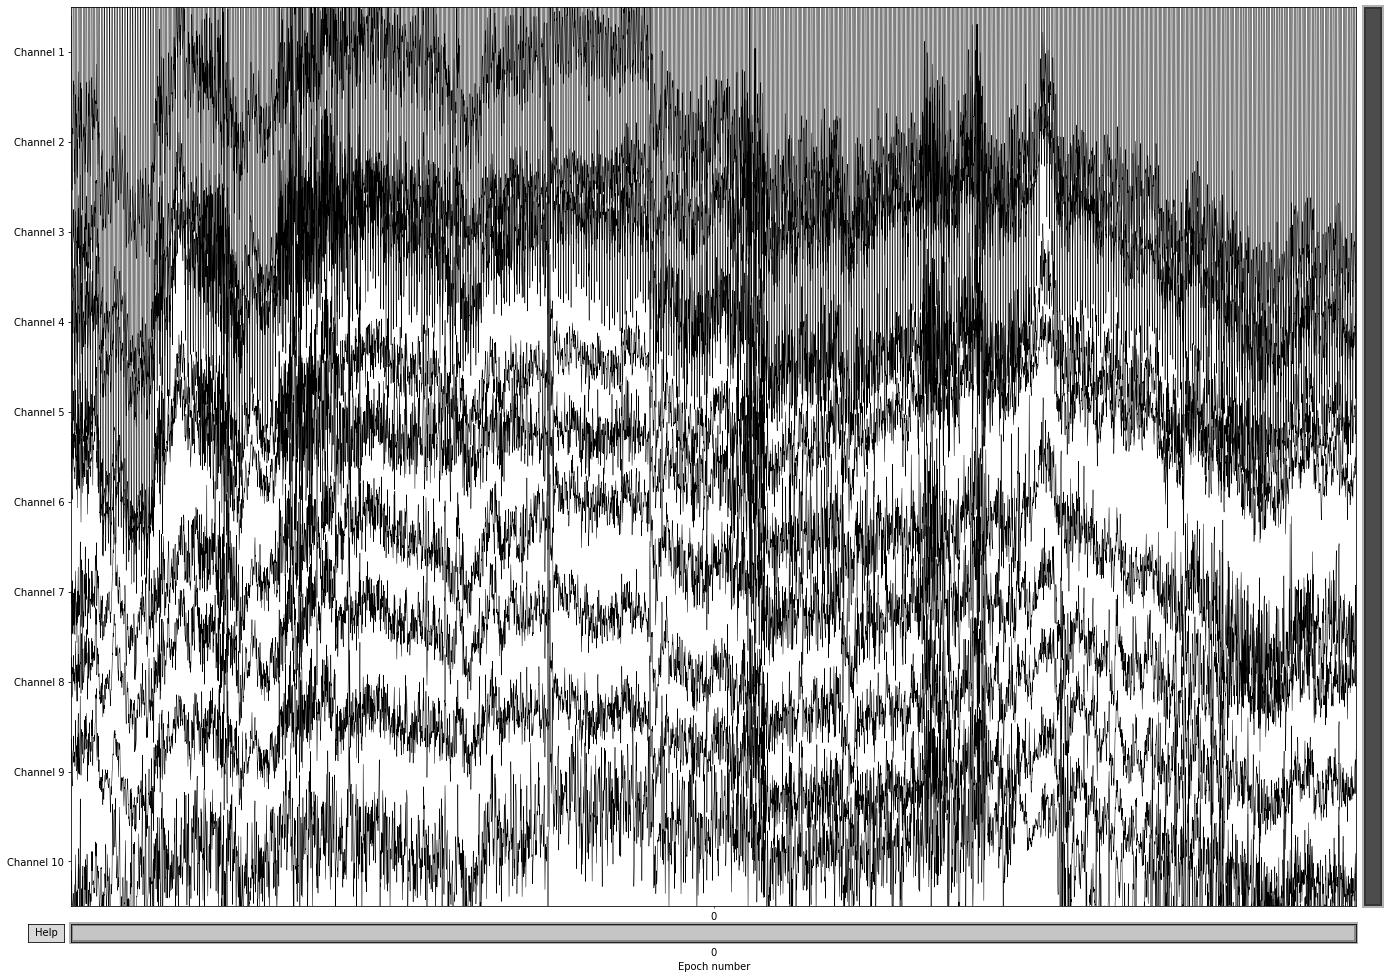

In [12]:
if display_preprocessing_plots:
    ep_plot = mne.make_fixed_length_epochs(raw, duration=10)[0].plot()

## Resample

In [13]:
if apply_resample:
    raw.resample(resample_freq)

In [14]:
a = [1,2,3]
a.extend([4,5])


In [15]:
print("Channel names from data: {}".format(raw.info['ch_names']))

montage = mne.channels.make_standard_montage('standard_1005')

if cname is None:
    cname = raw.info['ch_names']
    print('Using channel names directly from the data files: {}'.format(cname))
elif len(cname) < len(raw.info['ch_names']):
    
    # append missing channels to cname
    cname.extend(raw.info['ch_names'][len(cname) - len(raw.info['ch_names']):])
    print('Using user defined channel names and ignoring other channels: {}'.format(cname))
elif len(cname) > len(raw.info['ch_names']):
    print('Number of channels in data (n={}) is lower than the declared channel names {}'.format(len(raw.info['ch_names']), cname))
    raise
else:
    print('Using user defined channel names: {}'.format(cname))
        

nb_chan = len(raw.info['ch_names'])
nb_def_ch = len(cname)

# regular expressions to look for certain channel types
eog_pattern = re.compile('eog|EOG')  # EOG electrodes
emg_pattern = re.compile('emg|EMG')  # EMG electrodes
mastoid_pattern = re.compile('^[aA][0-9]+')  # A1 and A2 electrodes (mastoids)


types = []
cname_map = dict(zip(raw.info['ch_names'], cname))
for nc in cname:
    if eog_pattern.search(nc) is not None:
        t = 'eog'
    elif emg_pattern.search(nc) is not None:
        t = 'emg'
    elif mastoid_pattern.search(nc) is not None:
        t = 'misc'
    elif nc in montage.ch_names:  # check the 10-05 montage for all electrode names
        t = 'eeg'
    else:
        t = 'misc'  # if not found, discard the channel as misc
    
    types.append(t)
        
type_map = dict(zip(cname, types))

# rename and pick eeg
raw.rename_channels(cname_map, allow_duplicates=False)
raw.set_channel_types(type_map)
raw.pick_types(eeg=True, misc=False)
print('Electrode mapping')


Channel names from data: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10']
Using user defined channel names: ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']
Electrode mapping


rename the electrodes

Set the montage

In [16]:
cname_map

{'Channel 1': 'Fz',
 'Channel 2': 'FC1',
 'Channel 3': 'FC2',
 'Channel 4': 'C1',
 'Channel 5': 'Cz',
 'Channel 6': 'C2',
 'Channel 7': 'P3',
 'Channel 8': 'Pz',
 'Channel 9': 'P4',
 'Channel 10': 'Oz'}

In [17]:
raw.ch_names

['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']

In [18]:
raw = raw.set_montage(montage, match_case=False) 

Check whether there are bad channels 

Effective window size : 1.000 (s)
50Hz variance: []
Variance: []
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 2560 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2560 original time points ...
Loading data for 1 events and 2560 original time points ...


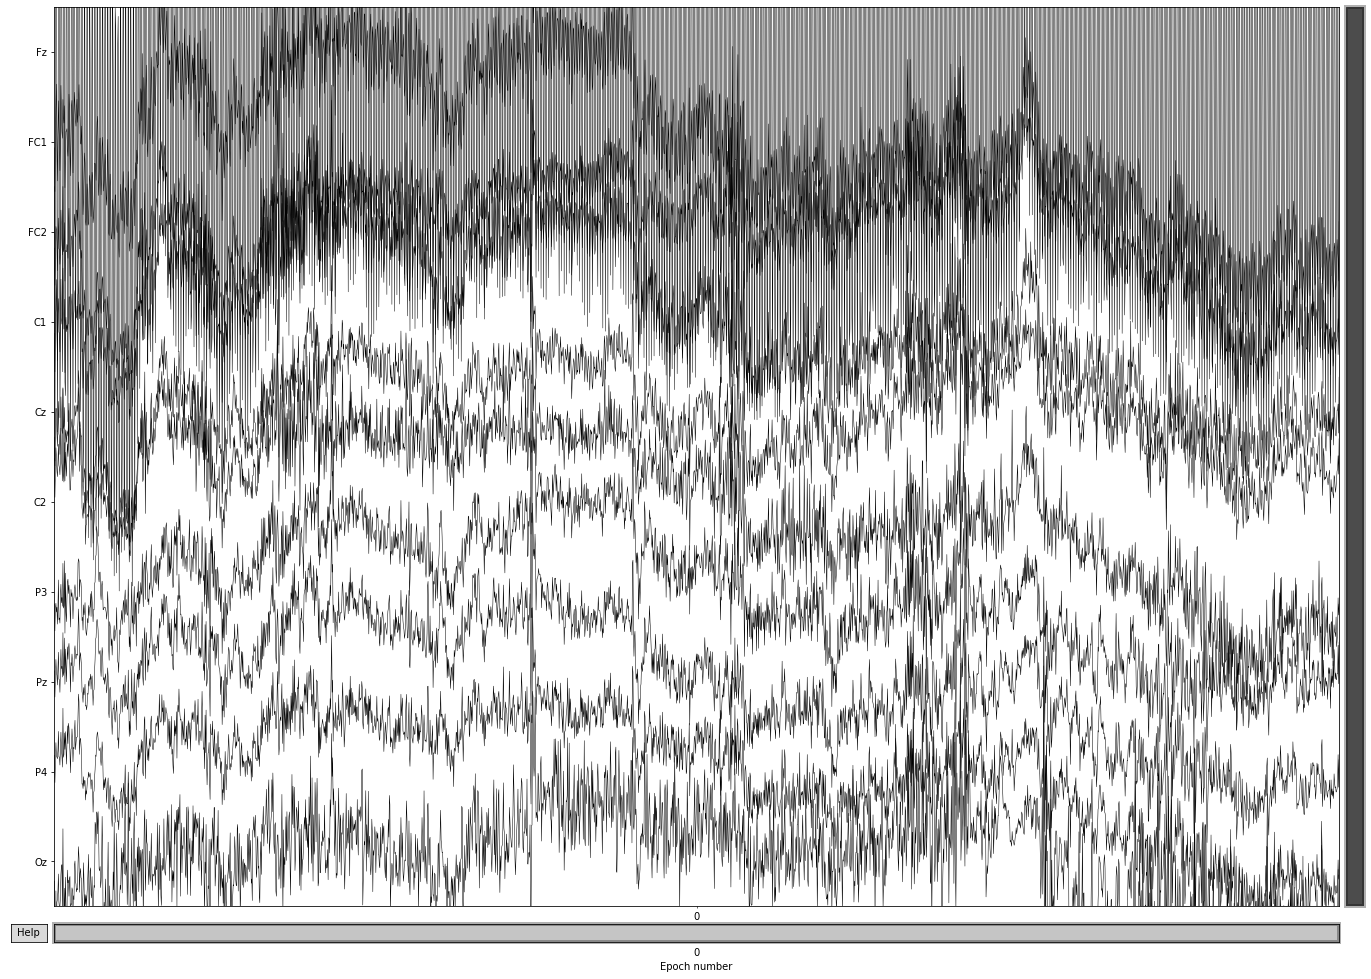

In [19]:
# Using 50Hz power variance
psd, freqs = mne.time_frequency.psd_welch(raw,verbose=True)
power_50hz = psd[:,np.where(freqs ==60)]
print('50Hz variance: {}'.format(mne.preprocessing.bads._find_outliers(power_50hz.squeeze(), threshold=3, max_iter=5, tail=0)))


# using variance
ch_var  = [np.var(raw._data[i,:]) for i in list(range(raw._data.shape[0]))]
print('Variance: {}'.format(mne.preprocessing.bads._find_outliers(ch_var, threshold=3, max_iter=5, tail=0)))

if display_preprocessing_plots:
    ep_plot = mne.make_fixed_length_epochs(raw, duration=10)[0].plot()

rereferencing

In [20]:
if apply_infinite_reference:
    raw.del_proj()  # remove our average reference projector first
    sphere = mne.make_sphere_model('auto', 'auto', raw.info)
    src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
    forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
    raw_rest = raw.copy().set_eeg_reference('REST', forward=forward)
    
    raw_short = ep_plot = mne.make_fixed_length_epochs(raw, duration=10)[0]
    raw_rest_short = mne.make_fixed_length_epochs(raw_rest, duration=10)[0]
    
    if display_preprocessing_plots:
        for title, _raw in zip(['Original', 'REST (∞)'], [raw_short, raw_rest_short]):
            
            fig = raw_short.plot(n_channels=raw_short.get_data().shape[1], scalings=dict(eeg=5e-5))
            # make room for title
            fig.subplots_adjust(top=0.9)
            fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

## Bandpass the signal
Removes noise and drift from the EEG signal by applying a infinite impulse response (two-pass) filter between .5 and 40Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 2560 

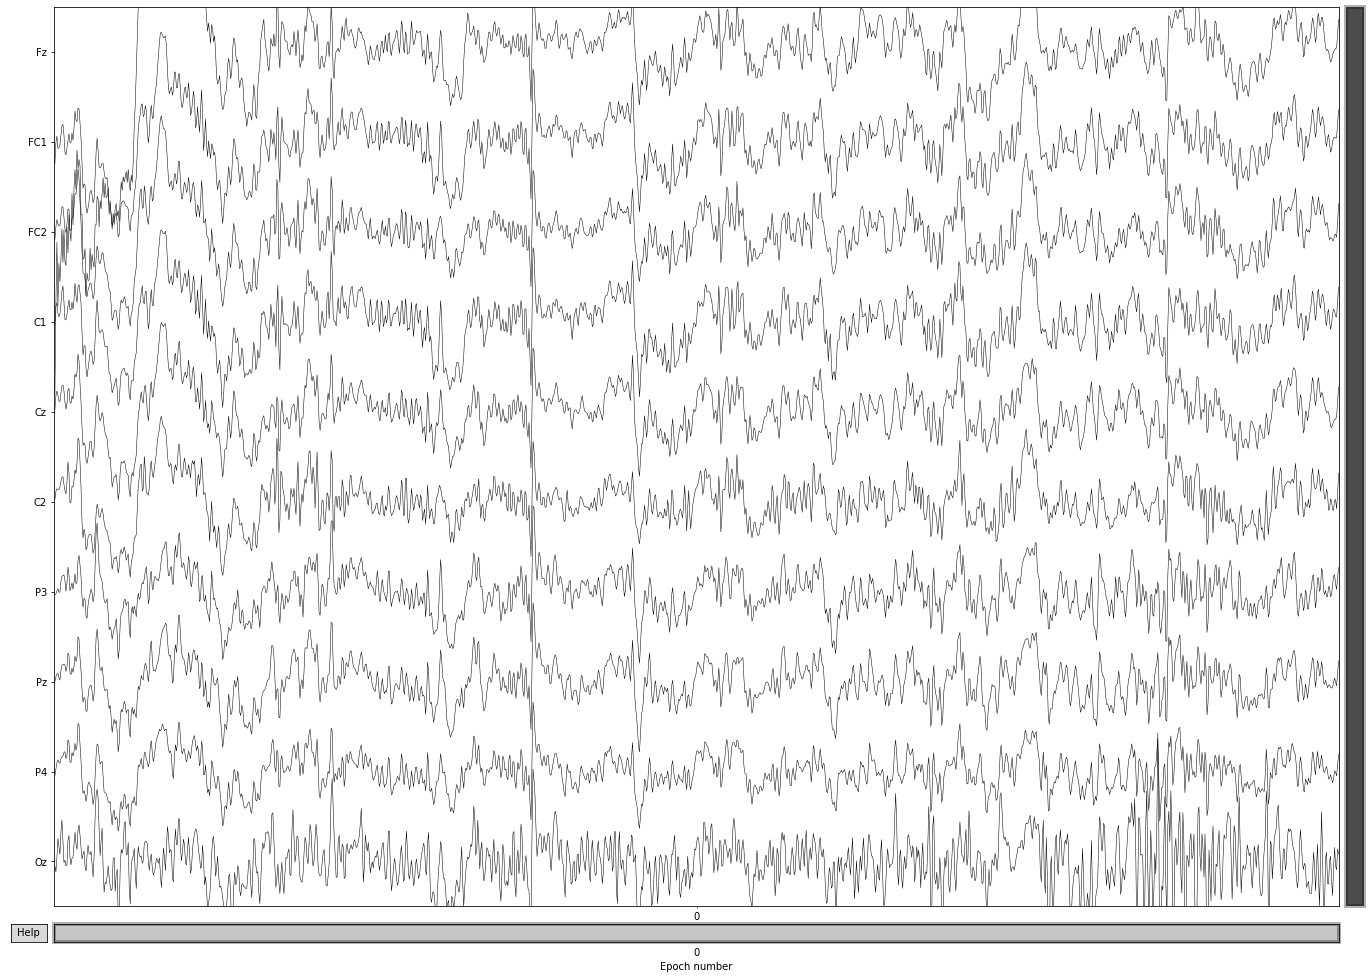

In [21]:
raw.filter(.5, 40, fir_window='hann', method='iir')
raw.notch_filter(50)  # removes 50Hz noise
if display_preprocessing_plots:
    fig = mne.make_fixed_length_epochs(raw, duration=10)[0].plot()
    fig.suptitle('Bandpassed')

## Excluding of channels full of artifacts (muscular or disconnecting)

In [22]:
import seaborn as sns
#Apply a variance based channel rejection if artifacts are present >30% of the time
def detec_rej_channel(raw, duration=.2, overlap_duration=.1, threshold_eeg=artifact_threshold, reject_ratio=ratio_tolerated_artifacts):

    epochs_rej = mne.make_fixed_length_epochs(raw,duration=duration, overlap=overlap_duration, preload=True)
    epochs_rej._data.shape
    diff = np.max(epochs_rej._data, axis=2) - np.min(epochs_rej._data, axis=2)

    print(diff.shape)

    rej = (diff>=threshold_eeg).astype(np.float64)
    rel = sns.heatmap(rej)
    rel.set(title='Detected artifacts per electrode and runs (white)')

    # calculate ratio of rejected trials
    ratios = np.sum(rej,axis=0) / rej.shape[0]
    
    ret = np.argwhere(ratios >= reject_ratio).tolist()
    if len(ret)>0 and len(ret[0]):
        print('Found {} channels with at least {}% {}s epochs > {} amplitude)'.format(len(ret), 
                                                                                              reject_ratio*100, duration,
                                                                                      threshold_eeg))
        return ret[0]
    else:
        return None
    
    
if reject_channels_full_of_artifacts:
    rej_ch = detec_rej_channel(raw)
    if rej_ch is not None:
        new_bads = [raw.info['ch_names'][ch] for ch in rej_ch]
        raw.info['bads'].extend(new_bads)
        raw.pick_types(eeg=True)


## Artifact Subspace Reconstruction fitting and reconstruction

In [23]:
if apply_ASR:
    #!pip install meegkit pymanopt
    from meegkit.asr import ASR
    fs = int(raw.info["sfreq"])  # sampling frequency
    method='riemann'  # if error, use 'euclid'
    method='euclid' # pymanopt library still buggy
    window_s=.5  # .5 sec window of analysis
    data_interval_s  = None # (begin, end) in sec of the training sample
    estimator='lwf'  #leave blank if using euclidian mode 

    # define the ASR model using riemannian method
    #asr_model = ASR(sfreq=fs, method=method, win_len=window_s, estimator=estimator)

    # if failing (after trying twice. SVD error occurs for no reason sometimes)
    asr_model = ASR(sfreq=fs, method=method, win_len=window_s)

    # The best would be to choose another recording during the same session to train the model without overfitting
    data = raw._data  # the numpy array with data is stored in the _data variable

    # Select a time interval for training data
    train_idx = None
    if data_interval_s is not None:
        train_idx = np.arange(data_interval_s[0] * fs, data_interval_s[1] * fs, dtype=int)
    # otherwise select the whole training set
    else:
        train_idx = np.arange(0, data.shape[1])

    train_data = data[:, train_idx]
    print('Training on samples of size {}'.format(train_data.shape))

    # fir the ASR model with data intervals
    _, sample_mask = asr_model.fit(train_data)
    print('Model trained')


### Clean the current dataset
Please check whether using this artifact filtering method increases signal to noise ratio rather than reducing it

In [24]:
if apply_ASR:
    clean =  asr_model.transform(raw._data)

    display_window_s = 60  # 

    if display_preprocessing_plots:  #
        data_p = raw._data[0:fs*display_window_s]  # reshape to (n_chans, n_times)
        clean_p = clean[0:fs*display_window_s]

        ###############################################################################
        # Plot the results
        # -----------------------------------------------------------------------------
        #
        # Data was trained on a 40s window from 5s to 45s onwards (gray filled area).
        # The algorithm then removes portions of this data with high amplitude
        # artifacts before running the calibration (hatched area = good).
        nb_ch_disp = len(raw.info['ch_names'])
        times = np.arange(data_p.shape[-1]) / fs
        f, ax = plt.subplots(nb_ch_disp, sharex=True, figsize=(32, 16))
        for i in range(nb_ch_disp):
            # ax[i].fill_between(train_idx / fs, 0, 1, color='grey', alpha=.3,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   label='calibration window')
            # ax[i].fill_between(train_idx / fs, 0, 1, where=sample_mask.flat,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   facecolor='none', hatch='...', edgecolor='k',
            #                   label='selected window')
            ax[i].plot(times, data_p[i], lw=.5, label='before ASR')
            ax[i].plot(times, clean_p[i], label='after ASR', lw=.5)
            # ax[i].plot(times, raw[i]-clean[i], label='Diff', lw=.5)
            # ax[i].set_ylim([-50, 50])
            ax[i].set_ylabel(f'ch{i}')
            ax[i].set_yticks([])
        ax[i].set_xlabel('Time (s)')
        ax[0].legend(fontsize='small', bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.subplots_adjust(hspace=0, right=0.75)
        plt.suptitle('Before/after ASR')
        plt.show()
    raw.data_ = clean

### Convert text annotations (i.e. unprocessed events) into events

**Small but major hack to realign events due to conversion**

In [25]:
if data_type=='openvibe':
    print("Erroneous annotations: {}".format(raw.annotations.description))
    print('Note here that the first annotation is 0 or 1, this is an error and thus we shift the annotations to retrieve the correct timings')
    raw.annotations.description = np.roll(raw.annotations.description, -1)
    print("Corrected annotations: {}".format(raw.annotations.description))

    # in case you want to debug the issue, I left here a way to visualize them
    # retrieving the list of annotations
    import pprint
    print(raw.annotations.to_data_frame())
    df = raw.annotations.to_data_frame()
    print('Displaying all annotations')
    annot_codes = [np.int64(n) for n in np.unique(df['description'])]
    df['description'] = df['description'].astype(int)

    if False:
        # to see and debug the fill list of annotations
        
        pd.set_option('display.max_rows', None)
        #a = df[df['description'] != 33286]
        #print(a)
        print(df)
        pd.set_option('display.max_rows', 32)

Erroneous annotations: ['1' '32773' '33035' ... '33286' '32779' '32780']
Note here that the first annotation is 0 or 1, this is an error and thus we shift the annotations to retrieve the correct timings
Corrected annotations: ['32773' '33035' '33286' ... '32779' '32780' '1']
                          onset  duration description
0    1970-01-01 00:00:11.876953  0.001953       32773
1    1970-01-01 00:00:11.876953  0.001953       33035
2    1970-01-01 00:00:11.876953  0.001953       33286
3    1970-01-01 00:00:11.876953  0.001953       32779
4    1970-01-01 00:00:11.939453  0.001953       32780
...                         ...       ...         ...
2805 1970-01-01 00:02:43.431641  0.001953       33030
2806 1970-01-01 00:02:43.431641  0.001953       33286
2807 1970-01-01 00:02:43.431641  0.001953       32779
2808 1970-01-01 00:02:43.494141  0.001953       32780
2809 1970-01-01 00:02:43.626953  0.001953           1

[2810 rows x 3 columns]
Displaying all annotations


### replace ov markers to match target and sequence indicators

In [26]:
if data_type=='openvibe':

    # replace openvibe stimuli by human readable ones
    map_replace_stim = {'33286':0, '33285':1, '32773':10}

    stim_ov_list = np.arange(ov_stimulus_begin, ov_stimulus_begin + ov_nb_row_stims + ov_nb_col_stims).astype(str)
    stim_list = np.arange(ov_nb_row_stims + ov_nb_col_stims)+ 1 + stimulus_padding # add 100 to stimuli 

    map_replace_stim.update(dict(zip(stim_ov_list, stim_list)))

    ov_nb_sequences = 10
    ov_nb_row_stims = 7
    ov_nb_col_stims = 7
    # delete segments that contain '0' or '1' stimuli
    raw.annotations.delete(np.where(raw.annotations.description=='0'))
    raw.annotations.delete(np.where(raw.annotations.description=='1'))
    raw.annotations.delete(np.where(raw.annotations.description.astype(np.uint8)>1000)[0]) # remove other stimulations

    # remap stimuli
    raw.annotations.description = pd.DataFrame(raw.annotations.description).replace(map_replace_stim).to_numpy().squeeze().astype(str)

### Make a list of the annotations to check whether all stimuli can be found

These annotations seem to relate to hex codes. OpenViBE definitions can be found on [OpenViBE's website](http://openvibe.inria.fr/stimulation-codes/). Let's parse the copypasted list

Make a dataframe of the stimuli in common between both

In [27]:
if data_type=='openvibe':
    tr_sim= ''
    pat_extract= re.compile('^([^ ]+)[ ]+0x[0-9A-Fa-f]+[ \/]+([0-9]+)')
    #OVTK_GDF_125_Watt                                     0x585       //  1413
    k_stim = []
    k_stim_int = []
    v_stim = []

    # read and convert annotations
    with open(r'.\ov_stims.txt', 'r') as fd:
        for line in fd.readlines():
            m = pat_extract.match(line)
            v, k = m.groups()
            k_stim.append(k)
            k_stim_int.append(int(k))
            v_stim.append(v)

    # format dict and list
    stim_map = dict(zip(k_stim_int, v_stim))
    stim_map_inv = dict(zip(v_stim, k_stim))

    stim_tup = list(zip(k_stim_int, v_stim))

    df = pd.DataFrame.from_dict(stim_tup)
    df.columns = ['coden', 'desc']
    df[[c in annot_codes for c in df.coden]]

From this table, we could locate and save the codes for **Target and Non-Target** and give them the following values: target=1 and non-target=0 

In [28]:
raw.annotations.description

array(['10', '111', '0', ..., '0', '32779', '32780'], dtype='<U11')

In [29]:
# Filter out string annotations
string_annotations = np.where(~np.apply_along_axis(np.char.isnumeric,0,raw.annotations.description))[0]
if string_annotations.size > 0:
    print('removing all string annotations: {}'.format(raw.annotations.description[string_annotations]))
    raw.annotations.delete(string_annotations)
# Extractz row and column labels from stimuli numbers
stimuli_labels = np.sort(np.unique(raw.annotations.description[np.where(raw.annotations.description.astype(np.uint8) >= stimulus_padding)]))

row_labels = stimuli_labels[:nb_stimlus_rows]
col_labels = stimuli_labels[nb_stimlus_rows:nb_stimlus_rows+nb_stimulus_cols]

print("Row labels: {}".format(row_labels))
print("Col labels: {}".format(col_labels))

# map the stimuli for MNE to read
map_stimuli = dict(zip(stimuli_labels, stimuli_labels.astype(np.uint8)))

Row labels: ['101' '102' '103' '104' '105' '106' '107']
Col labels: ['108' '109' '110' '111' '112' '113' '114']


In [30]:
map_stimuli

{'101': 101,
 '102': 102,
 '103': 103,
 '104': 104,
 '105': 105,
 '106': 106,
 '107': 107,
 '108': 108,
 '109': 109,
 '110': 110,
 '111': 111,
 '112': 112,
 '113': 113,
 '114': 114}

In [31]:
# target = 1, nontarget = 0
target_map = None
#if data_type == 'openvibe':
#    target_map = {'33286':0, '33285':1}
#elif data_type == "bci2000":
target_map = {'0':0, '1':1, '10':10}
target_map.update(map_stimuli)
target_map

{'0': 0,
 '1': 1,
 '10': 10,
 '101': 101,
 '102': 102,
 '103': 103,
 '104': 104,
 '105': 105,
 '106': 106,
 '107': 107,
 '108': 108,
 '109': 109,
 '110': 110,
 '111': 111,
 '112': 112,
 '113': 113,
 '114': 114}

Then we can convert annotations into events

In [32]:
all_events, event_id = mne.events_from_annotations(raw, event_id=target_map)
print("Found {} events".format(len(all_events[:])))
event_id

Used Annotations descriptions: ['0', '1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114']
Found 1405 events


{'0': 0,
 '1': 1,
 '10': 10,
 '101': 101,
 '102': 102,
 '103': 103,
 '104': 104,
 '105': 105,
 '106': 106,
 '107': 107,
 '108': 108,
 '109': 109,
 '110': 110,
 '111': 111,
 '112': 112,
 '113': 113,
 '114': 114}

In [33]:
raw.info["ch_names"]

['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']

### Pick the channels

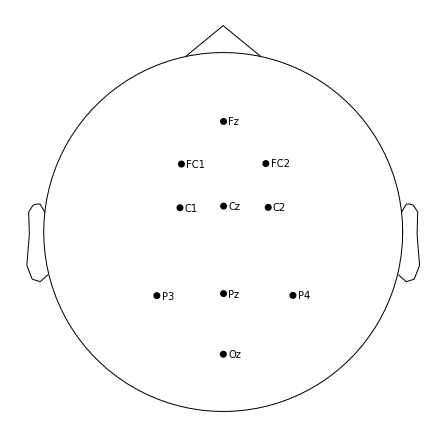

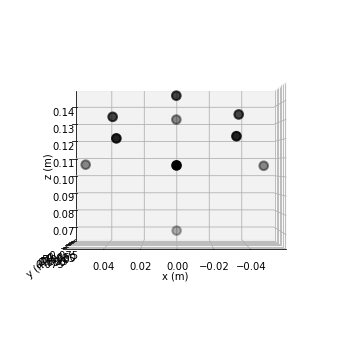

In [34]:
# pick all channels
picks = mne.pick_channels(raw.info["ch_names"], include=[])
picks
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

## Epoching from events

### Prepare metadata to annotate events
The goal here is to annotate every event with the Trial, stimulus and isRow information for offline accuracy calculations.\
It takes the shape of a dataframe with the number of events

In [35]:
# create the empty dataframe
nb_events = np.count_nonzero(np.where(all_events[:,2] <= 1))
df_meta = pd.DataFrame(data=None, index=list(range(0,nb_events)), columns=['Trial_nb', 'stim', 'is_row', 'is_col', 'is_target'])
ev = all_events.copy()
# populate with trial information
g_trial = np.split(all_events[:,2], np.where(all_events[:,2]==10)[0])[1:]


# iterate over trials to extract their metadata
cur_trial_n = 0
cursor=0
for g in g_trial:
    cur_trial_n += 1
    #print('Trial {}'.format(cur_trial_n))
    idx_stim_labs = np.where(g >= stimulus_padding)  
    stim_labels = g[idx_stim_labs]  # extract stimulus labels
    # isolate target and non_target stimuli
    targets_nontargets_phase = np.delete(g.copy(),idx_stim_labs)
    targets_nontargets = np.delete(targets_nontargets_phase,np.where(targets_nontargets_phase == 10))
    # extract the stimulus row/column information
    is_row = stim_labels <= nb_stimlus_rows+stimulus_padding
    
    # deduct the cursor over stimulus event
    end_cursor = cursor + len(targets_nontargets)
    
    # build up the metadata dataframe
    df_meta.loc[list(range(cursor, end_cursor)),'Trial_nb'] = cur_trial_n
    df_meta.loc[list(range(cursor, end_cursor)),'stim'] = stim_labels
    df_meta.loc[list(range(cursor, end_cursor)),'is_row'] = is_row.astype(np.uint8)
    df_meta.loc[list(range(cursor, end_cursor)),'is_col'] = np.invert(is_row).astype(np.uint8)
    df_meta.loc[list(range(cursor, end_cursor)),'is_target'] = targets_nontargets.astype(np.uint8)
    
    cursor = end_cursor
df_meta

,Trial_nb,stim,is_row,is_col,is_target
0,1,111,0,1,0
1,1,106,1,0,0
2,1,109,0,1,0
3,1,104,1,0,0
4,1,112,0,1,0
...,...,...,...,...,...
695,5,105,1,0,0
696,5,114,0,1,0
697,5,103,1,0,0
698,5,108,0,1,0


### Make epochs

Adding metadata with 5 columns
Replacing existing metadata with 5 columns
700 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 700 events and 206 original time points ...
0 bad epochs dropped


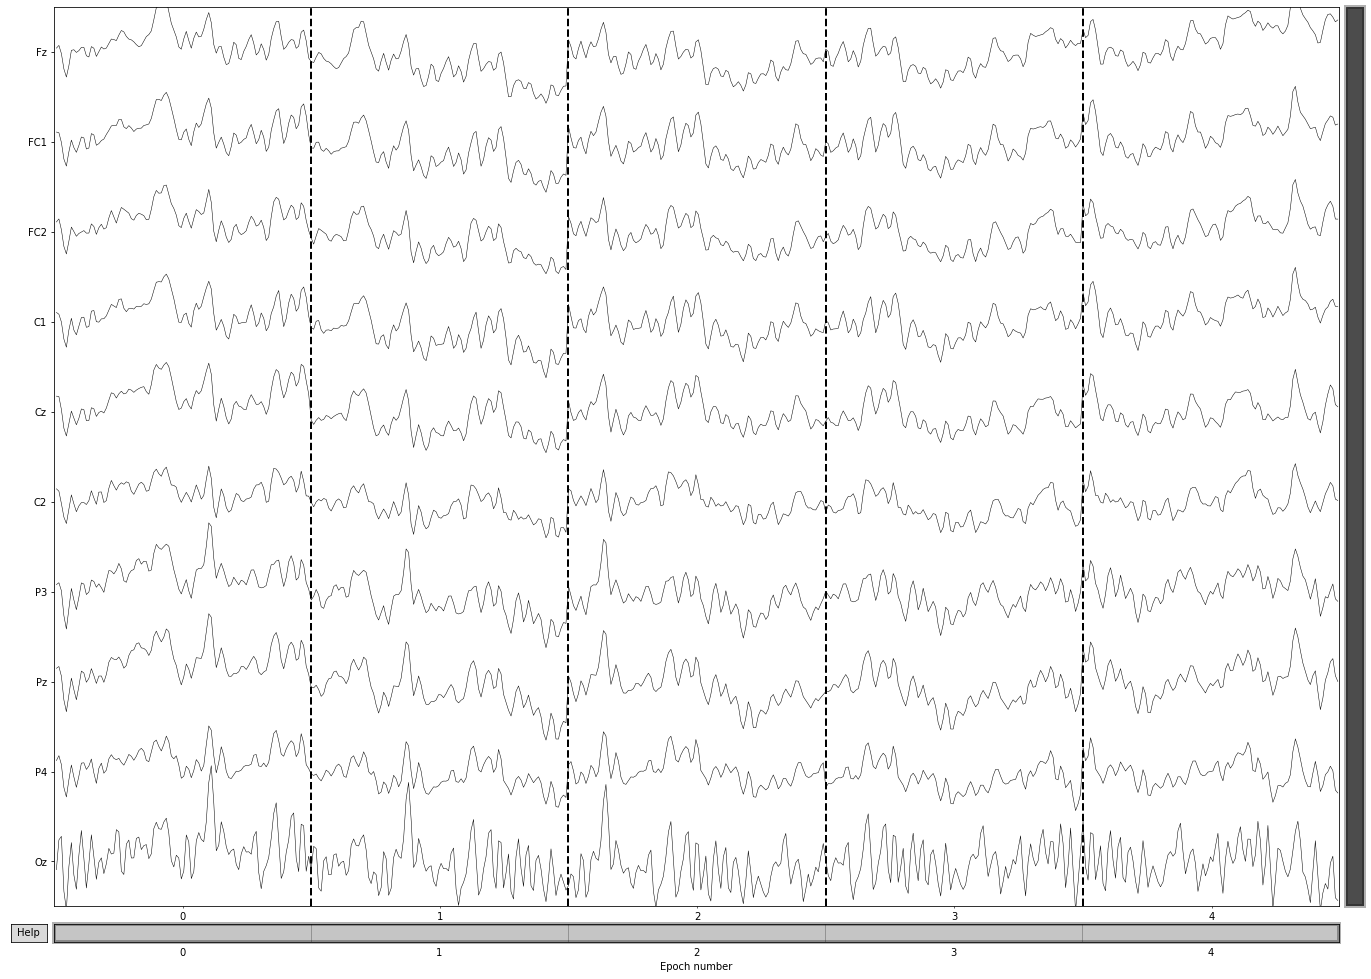

In [36]:
# since we use metadata we can pick only target and non-target events
events = mne.pick_events(all_events, [0,1])

event_ids = dict(NonTarget=0, Target=1) 

# epoching function
epochs = mne.Epochs(raw, events, baseline=time_baseline, event_id=event_ids, tmin=time_epoch[0], tmax=time_epoch[1], event_repeated='drop', picks = ['eeg', 'csd'],
                    preload=True, metadata=df_meta)

# if there is any delay,
#epochs.shift_time(-isi, relative=True)
if display_preprocessing_plots:
    fig = epochs[0:5].plot(title='displaying 5 first epochs')

using the metadata, we can now how many events are in our first epoch

### Making a cross correlation plot between the electrodes to see how channels relate

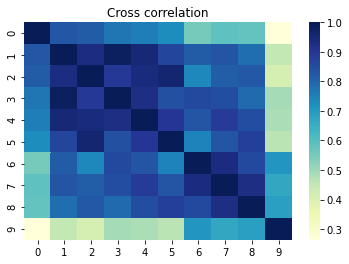

In [37]:
m = np.corrcoef(raw._data)
fig = plt.figure()
hm = sns.heatmap(m,linewidths=0,cmap="YlGnBu").set(title='Cross correlation')


### Epoch rejection
Please filter out channels before epochs. A problematic channel can discard the whole recording

In [38]:
if reject_artifactual_epochs:
    reject_criteria = dict(eeg=150e-6)  # 100 µV  #eog=200e-6)
    _ = epochs.drop_bad(reject=reject_criteria)
    if display_preprocessing_plots:
        epochs.plot_drop_log()

## Apply current source density

In [39]:
if apply_CSD:
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    epochs = epochs_csd
    if display_preprocessing_plots:
        fig = epochs_csd[0:5].plot(title='Current_source_density on 5 first epochs')


### Average the epochs of each class

In [40]:
l_nt = epochs['NonTarget'].average()
l_target = epochs['Target'].average()

target and non target signal plots

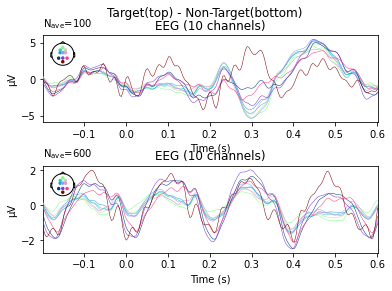

In [41]:
if display_all_erp_plots:
    fig, ax = plt.subplots(2, 1)
    fig1 = l_target.plot(spatial_colors=True, axes=ax[0], show=False)
    fig2 = l_nt.plot(spatial_colors=True, axes=ax[1], show=False)
    # Add title
    fig.suptitle("Target(top) - Non-Target(bottom)")
    # Fix font spacing
    plt.subplots_adjust(hspace=0.5)
    plt.show()

target and non target signal topomaps

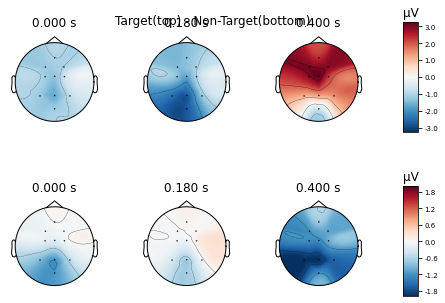

In [42]:
if display_all_erp_plots:
    spec_kw = dict(width_ratios=[1,1,1,.15], wspace=0.5,
                   hspace=0.5,height_ratios=[1,1])
                             #hspace=0.5, height_ratios=[1, 2])

    fig, ax = plt.subplots(2, 4, gridspec_kw=spec_kw)
    l_target.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[0,:], show=False)
    l_nt.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[1,:], show=False)
    fig.suptitle("Target(top) - Non-Target(bottom)")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

joint plot (of the two former graphs). Plase not that Y scales differ between plots 

No projector specified for this dataset. Please consider the method self.add_proj.


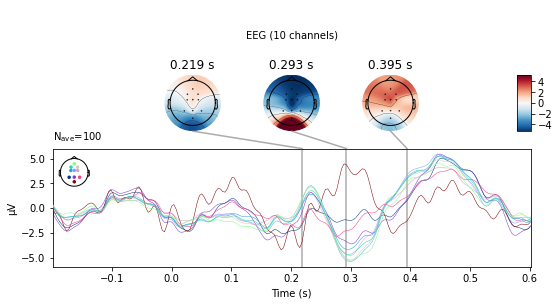

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 432x288 with 0 Axes>

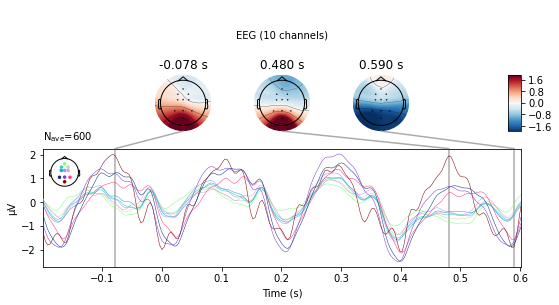

<Figure size 432x288 with 0 Axes>

In [43]:
l_target.plot_joint()
plt.gcf().canvas.set_window_title('Target joint plot')
l_nt.plot_joint()
plt.gcf().canvas.set_window_title('Non-Target joint plot')

Average plots

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


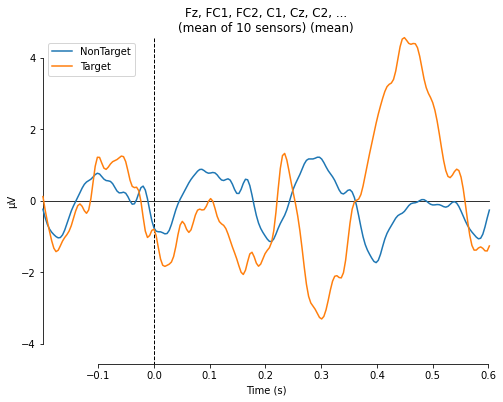

In [44]:
if display_all_erp_plots:
    #evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
    #               Target=list(epochs['Target'].iter_evoked()))
    evokeds = dict(NonTarget=epochs['NonTarget'].average(), 
           Target=epochs['Target'].average())
    #picks = [f'eeg{n}' for n in range(10, 15)]
    mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

### Target vs NonTarget Erps per channel

plotting channel 1
plotting channel 2
plotting channel 3
plotting channel 4
plotting channel 5
plotting channel 6
plotting channel 7
plotting channel 8
plotting channel 9
plotting channel 10
plotting averaged channels
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


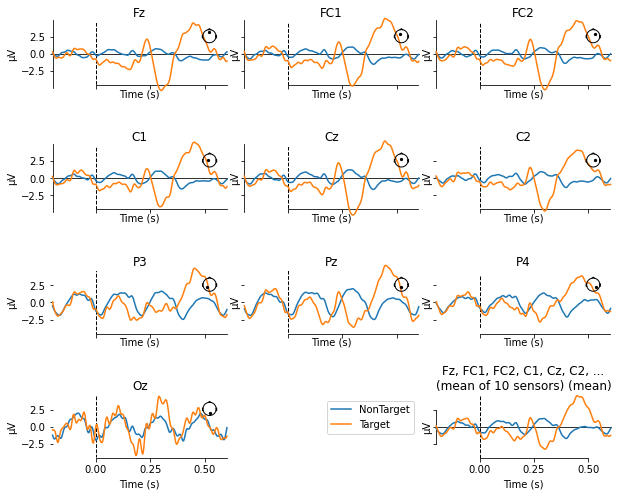

In [45]:


if not skip_slow_ERP_plot:
    nb_chans = epochs['Target']._data.shape[1]
    splt_width = int(np.floor(np.sqrt(1.0*nb_chans+2)))  # adding an extra plot with all channels combined at the end and a legend
    splt_height = splt_width if splt_width * splt_width >= nb_chans+1 else splt_width+1
    while splt_height * splt_width < nb_chans+2:
        splt_height += 1
    fig, axes = plt.subplots(splt_height,splt_width, figsize=(10,8),sharex=True, sharey=True)

    #evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
    #               Target=list(epochs['Target'].iter_evoked()))
    evokeds = dict(NonTarget=epochs['NonTarget'].average(), 
               Target=epochs['Target'].average())
    #picks = [f'eeg{n}' for n in range(10, 15)]

    shape_epochs = epochs['Target']._data.shape
    nb_cells = splt_height*splt_width
    for plot_idx in range(nb_cells):
        
        # cells containing data
        if plot_idx in range(nb_chans):
            ch_idx = plot_idx
            print('plotting channel {}'.format(ch_idx+1))
            mne.viz.plot_compare_evokeds(evokeds,picks=[epochs.info['ch_names'][ch_idx]],
                                         legend=False,
                                         axes=axes[plot_idx//splt_width, plot_idx%splt_width], show=False)
            #plt.show(block=False)
            plt.subplots_adjust(hspace=0.5, wspace=.5)
            #plt.pause(.05)
        
        # filler and legend cells
        elif plot_idx <= nb_cells-2:
            ax = axes[plot_idx//splt_width, plot_idx%splt_width] 
            ax.clear()  # clears the random data I plotted previously
            ax.set_axis_off()  # removes the XY axes
            
            if plot_idx == nb_cells-2:
                handles, labels = axes[0,0].get_legend_handles_labels()
                leg = ax.legend(handles, labels)
            
    print('plotting averaged channels')
    f = mne.viz.plot_compare_evokeds(evokeds, picks=epochs.info['ch_names'], combine='mean',
                                     legend=False,
                                     axes=axes[-1,-1], show=False)
        
        # retrieve the legend and move it in the previous cell

    plt.subplots_adjust(hspace=1, wspace=.1)
    plt.show()

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_ERPs')
    fig.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')

### Display single epochs

Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


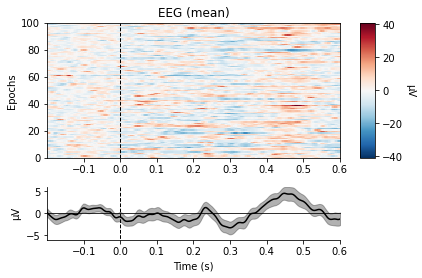

Not setting metadata
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


<Figure size 432x288 with 0 Axes>

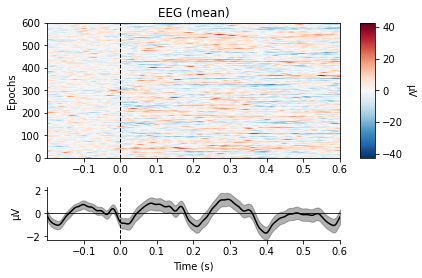

<Figure size 432x288 with 0 Axes>

In [46]:
if display_all_erp_plots:
    epochs['Target'].plot_image(combine='mean')
    plt.gcf().canvas.set_window_title('Target')
    epochs['NonTarget'].plot_image(combine='mean')
    plt.gcf().canvas.set_window_title('Non-Target')

### Same plot but channel wise

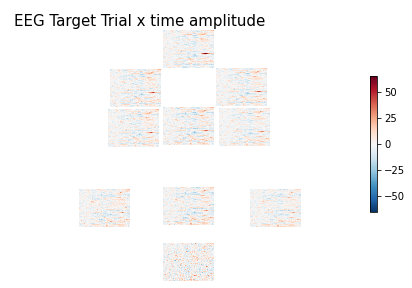

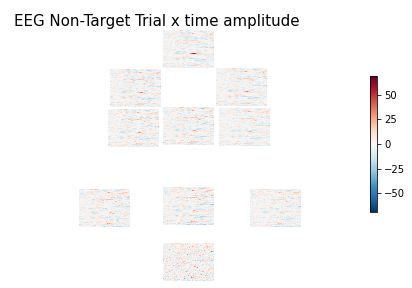

In [47]:
if not skip_slow_ERP_plot or True:
    dict_electrodes = dict(eeg='EEG') if not apply_CSD else dict(csd='CSD')
    if display_all_erp_plots:
        for ch_type, title in dict_electrodes.items():
            layout = mne.channels.find_layout(epochs.info, ch_type=ch_type)
            epochs['Target'].plot_topo_image(layout=layout, fig_facecolor='w',
                                                    font_color='k', title=title+' Target Trial x time amplitude')
            epochs['NonTarget'].plot_topo_image(layout=layout, fig_facecolor='w',
                                                    font_color='k', title=title+' Non-Target Trial x time amplitude')


# Classical LDA training

resample the signal, we don't need that much

In [48]:
new_fs = resample_LDA #
epochs_resampled = epochs.copy().resample(new_fs)
print('resampling to {}Hz'.format(new_fs))

resampling to 32Hz


modify the data matrix to be properly assessed via LDA

In [49]:
from sklearn import model_selection
X = epochs_resampled._data[:,1,:]  # input data at CZ (TODO:flatten all electrodes)
X = epochs_resampled._data[:,:,:]  # input data at CZ (TODO:flatten all electrodes)
y = epochs_resampled.events[:,2]  # ground truth

# remove the information 

def reshape_mne_raw_for_lda(X, verbose=False):
    # reshapes raw data for LDA, flattening the last dimension
    #mne.stats.permutation_t_test()
    if verbose:
        print('Data shape from MNE {}'.format(X.shape))
    X_out = np.moveaxis(X,1,-1)
    if verbose:
        print('new data shape with sampling prioritized over channels {}'.format(X_out.shape))
    X_out = X_out.reshape([X_out.shape[0],X_out.shape[1]*X_out.shape[2]],order='C')
    if verbose:
        print('Shape for K-fold LDA {}'.format(X_out.shape))
    return X_out

X = reshape_mne_raw_for_lda(X)

# Think about splitting training sample and test samples
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

### Compute k-fold LDA

In [50]:
clf = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
kf = KFold(n_splits=nb_k_splits)
kf.get_n_splits(X)

list_score = []
list_auc = []

for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X[train_index], X[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    clf.fit(X_train_kf, y_train_kf)
    kscore = clf.score(X_test_kf,y_test_kf)
    y_pred_kf = clf.predict(X_test_kf)
    k_auc = roc_auc_score(y_test_kf, y_pred_kf)
    print('fold score: {}, AUC={}'.format(np.round(kscore, decimals=3), np.round(k_auc, decimals=3)))
    list_score.append(kscore)
    list_auc.append(k_auc)
    
print('Average score {}-Fold = {}, AUC={}'.format(kf.get_n_splits(X), np.round(np.mean(list_score), decimals=2), np.round(np.mean(list_auc), decimals=2)))

# using the training/validate samples, 
clf.fit(X_train, y_train)
score  = clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

print('Score training-validation {}, AUC={}'.format(np.round(score , decimals=2), np.round(auc, decimals=2)))

print('Score is only valid if classes are balanced, please check AUC instead')

fold score: 0.964, AUC=0.896
fold score: 0.957, AUC=0.85
fold score: 0.9, AUC=0.733
fold score: 0.879, AUC=0.783
fold score: 0.929, AUC=0.833
Average score 5-Fold = 0.93, AUC=0.82
Score training-validation 0.94, AUC=0.84
Score is only valid if classes are balanced, please check AUC instead


In [51]:
nb_targets = epochs_resampled['Target'].events.shape[0]
nb_non_targets = epochs_resampled['NonTarget'].events.shape[0]

print('Data contains {}% of Non-targets'.format(np.round(100*(nb_non_targets / (epochs_resampled.events.shape[0])))))

Data contains 86.0% of Non-targets


### Display train-test LDA classification in a confusion matrix

,Pred 0(Non-Target),Pred 1(Target)
True 0(Non-Target),TN = 173 (TNR = 98.86%),FP = 2 (FPR = 1.14%)
True 1(Target),FN = 11 (FNR = 31.43%),TP = 24 (TPR = 68.57%)


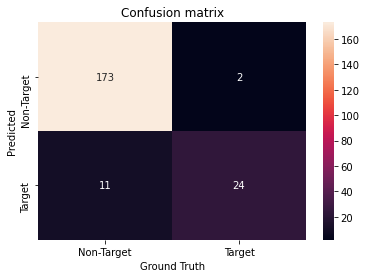

In [52]:

def conf_matrix(y,pred):
    cmat = metrics.confusion_matrix(y, pred)
    cmat_norm = metrics.confusion_matrix(y, pred, 
            normalize='true')
    ((tn, fp), (fn, tp)) = cmat
    ((tnr,fpr),(fnr,tpr)) = cmat_norm
    
    plt.figure()
    labels = ['Non-Target', 'Target']
    sns.heatmap(cmat, xticklabels=labels, yticklabels=labels, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    
    # alternative using sklearn plots
    #plt.figure()
    #from sklearn.metrics import ConfusionMatrixDisplay
    #cm_display = ConfusionMatrixDisplay(cmat).plot()
    
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Non-Target)', 'True 1(Target)'], 
            columns=['Pred 0(Non-Target)', 
                            'Pred 1(Target)'])
conf_matrix(y_test,y_pred)





## Process the ROC curve and precision recall

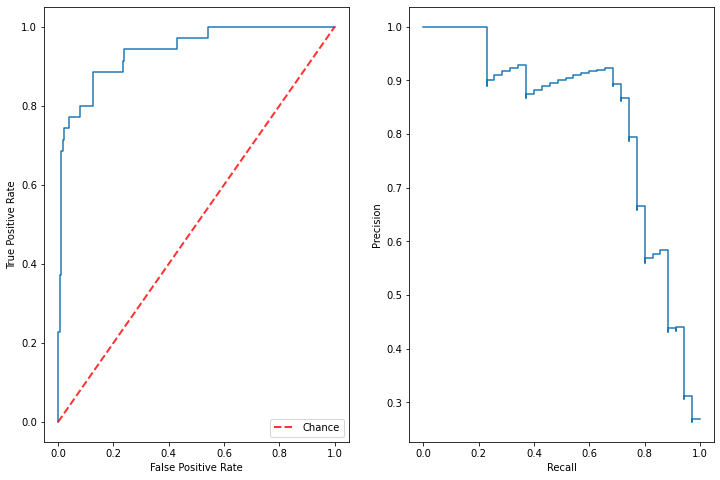

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
y_score = clf.decision_function(X_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)#.plot()


# Precision Recall Display
prec, recall, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)#.plot()

# Display them side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
roc_display.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax1.legend(loc="lower right")
pr_display.plot(ax=ax2)


if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_ROC')
    fig.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')
    
plt.show()

## Signed R-Square plot 

### Use the function from Wyrm

In [54]:
# From https://github.com/bbci/wyrm/blob/master/wyrm/processing.py
# Bastian Venthur for wyrm
# Code initially from Benjamin Blankertz for bbci (Matlab)

def calculate_signed_r_square_mne(epochs, classes=[0,1], classaxis=0, **kwargs):
    """Calculate the signed r**2 values.
    This method calculates the signed r**2 values over the epochs of the
    ``dat``.
    Parameters
    ----------
    epochs : MNE epoched data
    classes: list, optional 
        (either int index or str for the class name of the epoch))
    classaxis : int, optional
        the dimension containing epochs
    Returns
    -------
    signed_r_square : ndarray
        the signed r**2 values, signed_r_square has one axis less than
        the ``dat`` parameter, the ``classaxis`` has been removed
    Examples
    --------
    >>> dat.data.shape
    (400, 100, 64)
    >>> r = calculate_signed_r_square(dat)
    >>> r.shape
    (100, 64)
    """
    # TODO: explain the algorithm in the docstring and add a reference
    # to a paper.
    # select class 0 and 1
    # TODO: make class 0, 1 variables
    fv1 = epochs[classes[0]]._data
    fv2 = epochs[classes[1]]._data
    # number of epochs per class
    l1 = epochs[classes[0]]._data.shape[classaxis]
    l2 = epochs[classes[1]]._data.shape[classaxis]
    # calculate r-value (Benjamin approved!)
    a = (fv1.mean(axis=classaxis) - fv2.mean(axis=classaxis)) * np.sqrt(l1 * l2)
    b = epochs._data.std(axis=classaxis) * (l1 + l2)
    r = a / b
    # return signed r**2
    return np.sign(r) * np.square(r)

rsq = calculate_signed_r_square_mne(epochs, classes=['Target','NonTarget'])

### make a pandas database to properly display electrodes and samples

In [55]:
# make a pandas database to properly display electrodes and samples
fs = epochs.info['sfreq']
x = np.float64(list(range(rsq.shape[1])))*(1000/fs)
x = x.round(decimals=0).astype(np.int64) + np.int64(time_epoch[0]*1000)
df_rsq = pd.DataFrame(rsq, columns=x, index=epochs.info['ch_names'])

### Plot rsq

note that using a larger sampling rate will smooth this figure

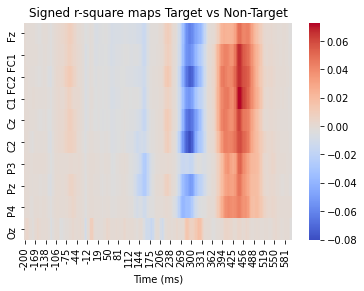

In [56]:
plt.figure()
hm = sns.heatmap(df_rsq,linewidths=0,cmap="coolwarm").set(title='Signed r-square maps Target vs Non-Target', xlabel='Time (ms)')

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_heatmap' )
    plt.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')


### Quickly Display a channel with max rsq

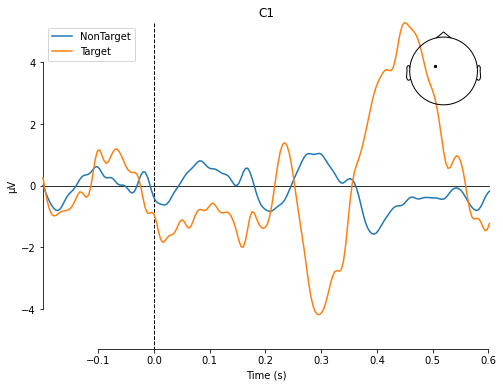

In [57]:
picks = None  # <- specify the channel here or it will be selected automatically
if picks is None:
    ch_max, _ = np.where(rsq == np.max(rsq))
    picks = epochs.info['ch_names'][int(ch_max)]

#picks = [f'eeg{n}' for n in range(10, 15)]
#evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
#               Target=list(epochs['Target'].iter_evoked()))

evokeds = dict(NonTarget=epochs['NonTarget'].average(), 
           Target=epochs['Target'].average())
axs = mne.viz.plot_compare_evokeds(evokeds, picks=picks)  # use combine='mean' if several electrode chosen in picks

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_best_channel')
    axs[0].savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')



# Extract offline analysis, using shrinkage LDA

### Extract correct target pair

In [58]:
def extract_target(epochs, trial_nb):
    #epoch_trial = epochs[epochs.metadata['Trial_nb'] == trial_nb]
    assert (epochs.metadata['Trial_nb'] == trial_nb).size > 0, 'Trial number not found in metadata'
    idx_targets = np.where(np.logical_and(epochs.metadata['Trial_nb'] == trial_nb, 
                                          epochs.metadata['is_target']))[0]
    # extract target or target pair
    target_pair = np.sort(np.unique(epochs.metadata.loc[idx_targets]['stim'])).astype(np.uint8)
    # remove the stimulus pardding to give it a meaning
    return target_pair - stimulus_padding



#### Custom functions to extract performance in a cumulative way 
By cumulative, it uses either the first sequence, then first and second, and so on until all sequences are considered.\
This allows for choosing an optimal number of sequences

In [59]:
def predict_cumulative(clf, X, step):
    """
    Repeats a function on the first axis on the 2d data"""
    array_out = [clf.predict(X[0:cursor_seq,:]) for cursor_seq in np.arange(0,X.shape[0], step) + step]
    return array_out

def predict_proba_cumulative(clf, X, step):
    """
    Repeats a function on the first axis on the 2d data"""
    array_out = [clf.predict_proba(X[0:cursor_seq,:]) for cursor_seq in np.arange(0,X.shape[0], step) + step]
    return array_out

def score_cumulative(clf, X, y,  step):
    """
    Repeats a function on the first axis on the 2d data"""
    array_out = [clf.score(X[0:cursor_seq,:], y[0:cursor_seq]) for cursor_seq in np.arange(0,X.shape[0], step) + step]
    return array_out

def auc_cumulative(y, y_preds_cumulative,  step):
    array_out = []
    for i in range(0, y.shape[0]//step):
        y_pred = y_preds_cumulative[i]
        y_gt = y[0:step*(i+1)]
        roc = roc_auc_score(y_gt, y_pred)
        array_out.append(roc)
        
    #one liner not working TT
    #array_out = [roc_auc_score(y[0:cursor_seq], y_preds_cumulative[(cursor_seq//step)-1]) for cursor_seq in np.arange(0,y.shape[0], step) + step]
    return array_out

# Transform into a function

def stim_from_predict_cumulative(predicted, stim_labels, nb_stim_in_sequence=None):
    """
    takes the output of predict_proba and returns the predicted target.
    :param predicted: 
    :param stim_labels: stimulus labels from the epochs 
    :param len_repetition: number of stimuli in a sequence
    :return: preicted target stimulus
    :note: if no target was found by LDA, it will use best candidates based 
    """
    # retrieve the target probability index
    max_proba_class = np.argmax(predicted,axis=1)
    
    # In case LDA returns no results
    if np.max(max_proba_class) == 0:
        #print('(note:LDA detected no target when classifying n={} epochs, using best target candidate instead)'.format(predicted.shape[0]))
        #max_proba_class[[np.argmax(predicted[:,1])]] = 1
        print("- LDA detected no target in this iteration of length {}."
              " Marking best candidate as target every {} prediction".format(predicted.shape[0], nb_stim_in_sequence))
        for step_seq in range(0,max_proba_class.size, nb_stim_in_sequence):
            idx_seq_step = list(range(step_seq,step_seq+nb_stim_in_sequence))
            max_proba_class[[idx_seq_step[0] + np.argmax(predicted[idx_seq_step,1])]] = 1
                                                                                               
    # extract probabilities
    max_proba = np.array([predicted[idx,max_proba_class[idx]] for idx in list(range(predicted.shape[0]))])
    # target_indices
    target_epochs_idx = np.where(max_proba_class)
    # extract target stimuli from the list of stimuli and put them in a table with their respective probability
    predicted_target_stims = stim_labels[target_epochs_idx].astype(np.uint8)
    pred_targets_table = np.vstack((predicted_target_stims, max_proba[target_epochs_idx]))
    # sum up target probability in this table stimulis-wise (thus dealing with situations with draws)
    potential_targets = np.unique(pred_targets_table[0,:])
    sum_proba_targets = [np.sum(pred_targets_table[1,np.where(pred_targets_table[0,:]==target_candidate)]) for target_candidate in potential_targets]
    pred_targets_table_reduced = np.vstack((potential_targets, sum_proba_targets))

    # return the stimulation with the highest average probability
    predicted_stim = pred_targets_table_reduced[0,np.argmax(pred_targets_table_reduced[1,:])].astype(np.uint8)
    
    return predicted_stim

#### Resampling for faster LDA

In [60]:
new_fs = resample_LDA #
epochs_resampled = epochs.copy().resample(new_fs)
print('resampling to {}Hz'.format(new_fs))

resampling to 32Hz


#### Checking whether the number of folds matches the total number of trials

In [61]:
# Check whether we can proceed to k split
list_trials = np.unique(epochs_resampled.metadata["Trial_nb"])

print("nb_trials:{}, nb_folds:{}".format(list_trials.size, nb_k_splits))
assert list_trials.size // nb_k_splits == list_trials.size / nb_k_splits, 'number of splits must be a multiple of the number of trials'

nb_trials:5, nb_folds:5


#### LDA for P300 speller target prediction 

In [62]:
clf = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')

kf = KFold(n_splits=nb_k_splits)

# make a table to store the scores and accuracies
score_table = pd.DataFrame({'fold' : pd.Series([], dtype='int'),
                            'fold_trial' : pd.Series([], dtype='int'),
                            'n_seq' : pd.Series([], dtype='int'),
                            'score' : pd.Series([], dtype='float'),
                            'AUC' : pd.Series([], dtype='float'),
                            'row_true' : pd.Series([], dtype='str'),
                            'row_pred' : pd.Series([], dtype='str'),
                            'col_true' : pd.Series([], dtype='str'),
                            'col_pred' : pd.Series([], dtype='str'),
                            'correct' : pd.Series([], dtype='int')})

fold_counter = 0
for train_index, test_index in kf.split(list_trials):
    a = test_index
    
    
    # define the training sample
    X_train = epochs_resampled[epochs_resampled.metadata['Trial_nb'].isin(list_trials[train_index])]._data
    y_train = epochs_resampled[epochs_resampled.metadata['Trial_nb'].isin(list_trials[train_index])].metadata['is_target'].astype(np.uint8)
    y_train_stim = epochs_resampled[epochs_resampled.metadata['Trial_nb'].isin(list_trials[train_index])].metadata['stim']

    # reshape data to enter LDA
    X_train = reshape_mne_raw_for_lda(X_train)
    
    # train the LDA classifier
    clf.fit(X_train, y_train)
    
    # split the tests samples for each individual trial enable P300 speller target prediction and accuracy
    nb_test_trials_in_split = len(list_trials)
    for i_trial in list(range(len(test_index))):
        trial_nb = test_index[i_trial]+1
    
        # both row and columns for generic classification
        epoch_test = epochs_resampled[epochs_resampled.metadata['Trial_nb'] == trial_nb]
        X_test = epoch_test._data
        y_test = epoch_test[epoch_test.metadata['Trial_nb'] == trial_nb].metadata['is_target'].astype(np.uint8)

        # separate row and columns target detection
        epoch_rows = epoch_test[np.where(epoch_test.metadata['is_row'])[0]]
        epoch_cols = epoch_test[np.where(epoch_test.metadata['is_col'])[0]]
        
        skip_rows = False
        if np.where(epoch_rows.metadata['is_target']==1)[0].size == 0:
            print('Skipping epochs with no target rows')
            skip_rows = True
        else:
            X_test_rows = epoch_rows[epoch_rows.metadata['Trial_nb'] == trial_nb]._data
            y_test_rows = epoch_rows[epoch_rows.metadata['Trial_nb'] == trial_nb].metadata['is_target'].astype(np.uint8)
            y_test_rows_stim = epoch_rows[epoch_rows.metadata['Trial_nb'] == trial_nb].metadata['stim']
            X_test_rows = reshape_mne_raw_for_lda(X_test_rows)  # reshape for LDA
            
        skip_cols = False
        if np.where(epoch_cols.metadata['is_target']==1)[0].size == 0:
            skip_cols = True
            print('Skipping epochs with no target columns')
        else:
            X_test_cols = epoch_cols[epoch_cols.metadata['Trial_nb'] == trial_nb]._data
            y_test_cols = epoch_cols[epoch_cols.metadata['Trial_nb'] == trial_nb].metadata['is_target'].astype(np.uint8)
            y_test_cols_stim = epoch_cols[epoch_cols.metadata['Trial_nb'] == trial_nb].metadata['stim']
            X_test_cols = reshape_mne_raw_for_lda(X_test_cols)  # reshape


        # reshape data to enter LDA
        X_test = reshape_mne_raw_for_lda(X_test)
        
       

        # predict the targets for rows, (1 to N sequences cumulative X information provided)
        y_pred = clf.predict(X_test)

        # update this when dealing with rows and columns to X_test_rows and X_test_cols
        step = X_test.shape[0]//nb_seq

        # score
        score_cum = score_cumulative(clf, X_test, y_test, step) 
        # probas calculated for prediction (aggregation will lead to cumulative prediction)
        #proba_cum = proba_cumulative(clf, X_test, y_test, step)
        y_test_pred_cum = predict_cumulative(clf, X_test, step)
        # area under the curve
        auc_cum = auc_cumulative(y_test, y_test_pred_cum, step)

        if not skip_rows:
            # prediction stim_rows
            step_rows = X_test_rows.shape[0]//nb_seq
            proba_cum_rows = predict_proba_cumulative(clf, X_test_rows, step_rows)
            pred_stim_rows_cum = np.array([stim_from_predict_cumulative(predicted=proba_cum_rows[i],
                                                                        stim_labels=epoch_rows.metadata['stim'].to_numpy(),
                                                                        nb_stim_in_sequence=step_rows)
                                  for i in list(range(len(proba_cum_rows)))])
            true_target_rows = np.unique(epoch_rows.metadata.iloc[np.where(epoch_rows.metadata['is_target']==1)]['stim'])[0]  # does not handle k fold with several trials
            rows_successul = pred_stim_rows_cum == true_target_rows
            
        if not skip_cols:
            # columns
            step_cols = X_test_cols.shape[0]//nb_seq
            proba_cum_cols = predict_proba_cumulative(clf, X_test_cols, step_cols)
            pred_stim_cols_cum = np.array([stim_from_predict_cumulative(predicted=proba_cum_cols[i],
                                                                        stim_labels=epoch_cols.metadata['stim'].to_numpy(),
                                                                       nb_stim_in_sequence=step_cols)
                                  for i in list(range(len(proba_cum_cols)))])
            true_target_cols = np.unique(epoch_cols.metadata.iloc[np.where(epoch_cols.metadata['is_target']==1)[0]]['stim'])[0]  # does not handle k fold with several trials
            cols_successul = pred_stim_cols_cum == true_target_cols
            
            
        if not skip_rows and not skip_cols:
            successful_pred_cum = np.logical_and(rows_successul, cols_successul).astype(np.uint8)
        elif skip_rows and skip_cols:
            raise
        elif skip_rows:
            successful_pred_cum = cols_successul
        elif skip_cols:
            successful_pred_cum = rows_successul


        # Associate predicted targets to stimuli
        for i in range(len(score_cum)):
            line = dict(zip(score_table.columns, [fold_counter+1, i_trial+1, i+1, # fold, fold_trial, nb of sequences
                                                  score_cum[i], 
                                                  auc_cum[i],true_target_rows, pred_stim_rows_cum[i],
                                                  true_target_cols, pred_stim_cols_cum[i], successful_pred_cum[i]]))

            score_table = score_table.append(line, ignore_index=True)



        print('fold {} partial score: {}, AUC={}'.format(fold_counter, np.round(score_cum[-1], decimals=3), np.round(auc_cum[-1], decimals=3)))

        #print('----row score: {}, AUC={}'.format(np.round(kscore_rows, decimals=3), np.round(auc_rows, decimals=3)))
        #print('----col score: {}, AUC={}'.format(np.round(kscore_cols, decimals=3), np.round(auc_cols, decimals=3)))
    fold_counter += 1
    
# clear the types or the score table
score_table[["row_true", "row_pred", "col_true", "col_pred"]] = score_table[["row_true", "row_pred", "col_true", "col_pred"]] -100
score_table = score_table.convert_dtypes()
pass

fold 0 partial score: 0.964, AUC=0.896
fold 1 partial score: 0.957, AUC=0.85
- LDA detected no target in this iteration of length 7. Marking best candidate as target every 7 prediction
- LDA detected no target in this iteration of length 14. Marking best candidate as target every 7 prediction
fold 2 partial score: 0.9, AUC=0.733
fold 3 partial score: 0.879, AUC=0.783
- LDA detected no target in this iteration of length 7. Marking best candidate as target every 7 prediction
fold 4 partial score: 0.929, AUC=0.833


#### Prediction results
**fold**: k-fold\
**fold_trial**: index of trial contained in the fold\
**n_seq**: number of sequences selecting epoch for predictions\
**score**: LDA score (target vs non-target detection). Classes are unbalanced so the score is misleading\
**AUC**: LDA Area Under the Curve. Estimation of the performance of the classifier\
**row/col_pred/true**: row and columns target and predicted\
**correct**: the predicted row **AND** column is correctly predicted

In [63]:
score_table[:]

,fold,fold_trial,n_seq,score,AUC,row_true,row_pred,col_true,col_pred,correct
0,1,1,1,0.928571,0.958333,1,1,8,8,1
1,1,1,2,0.964286,0.979167,1,1,8,8,1
2,1,1,3,0.97619,0.986111,1,1,8,8,1
3,1,1,4,0.982143,0.989583,1,1,8,8,1
4,1,1,5,0.971429,0.941667,1,1,8,8,1
5,1,1,6,0.964286,0.909722,1,1,8,8,1
6,1,1,7,0.969388,0.922619,1,1,8,8,1
7,1,1,8,0.973214,0.932292,1,1,8,8,1
8,1,1,9,0.968254,0.912037,1,1,8,8,1
9,1,1,10,0.964286,0.895833,1,1,8,8,1


#### Make a human readable plot of these results

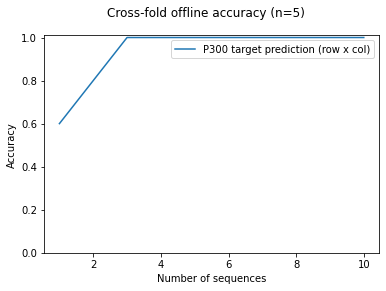

Number of ERP targets=100, non-targets=600


In [64]:
df_seq = score_table.groupby(['n_seq']).mean()
df_seq = df_seq.rename(columns={"correct":"Accuracy", "score":"epoch_score", "AUC":"epoch_AUC"})
df_seq[['Accuracy','epoch_score', 'epoch_AUC']]

df_seq.plot(y='Accuracy')
plt.ylim(0, 1.01)
plt.suptitle('Cross-fold offline accuracy (n={})'.format(nb_k_splits))
plt.xlabel('Number of sequences')
plt.ylabel('Accuracy')
plt.legend(['P300 target prediction (row x col)'])
# export the figure
out_name = os.path.join(fig_folder, output_name + '_accuracy')
plt.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print("Number of ERP targets={}, non-targets={}".format(epochs['Target']._data.shape[0], epochs['NonTarget']._data.shape[0]))

